# Mapping lineage-traced cells across time points with moslin

In this tutorial, we showcase how to use lineage and gene expression information to link cells across time points with [moslin](https://github.com/theislab/moslin). Lineage information helps to regularize our mappings and enables us to analzye complex cellular state-change trajectories. In this tutorial, we demonstrate moslin on TedSim {cite}`pan:22` simluated data. 

Under the hood, moslin is based on moscot; we use the {class}`~moscot.problems.time.LineageProblem` to solve the Fused-Gromov Wasserstein problem of relating lineage and gene expression across time. 


:::{seealso}
- See our {doc}`../examples/problems/600_leaf_distance` example on how to compute distances along a lineage tree. 
- See our {doc}`200_temporal_problem` tutorial on how to link cells across time points without lineage information. 
- TODO: Link to the barcode distance example
:::

## Preliminaries

In [1]:
import warnings

import moscot as mt
import moscot.plotting as mpl
from moscot import datasets
from moscot.problems.time import LineageProblem, TemporalProblem
from moscot.base.output import MatrixSolverOutput
import ot

from sklearn.metrics.pairwise import euclidean_distances
from typing import Literal, Optional, List, Tuple
import tqdm

import networkx as nx
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", UserWarning)

### Define utility functions

Iterate over the rows or columns in two coupling matrices and compute their EMDs. 

In [2]:
def _compute_w2(
    p_1: np.array,
    p_2: np.array,
    cost: np.array,
    metric_type: Literal["descendant", "ancestor"],
    scale_by_marginal: bool = True,
) -> List:
    
    # initialize an empty list to store the errors per cell
    errors = []

    # transpose for ancestors
    if metric_type == "ancestor":
        p_1 = p_1.T
        p_2 = p_2.T

    # iterate over all cells
    for i in tqdm.tqdm(range(p_1.shape[0])):
        
        # normalize to get distributions
        marginal = p_1[i].sum()
        dist_1 = p_1[i] / marginal
        dist_2 = p_2[i] / p_2[i].sum()

        # compute the EMD distance between ground-truth and predicted distibution
        assert (dist_1.dtype == np.float64), "dist_1 is not float64"
        assert (dist_2.dtype == np.float64), "dist_2 is not float64"
        assert (cost.dtype == np.float64), "cost is not float64"
        error, log = ot.emd2(dist_1, dist_2, cost, log=True)

        # append the EMD (potentially scaled by the marignal)
        if log["warning"] is None:
            if scale_by_marginal:
                errors.append(marginal * error)
            else:
                errors.append(error)
        else:
            errors.append(np.nan)

    return errors

Obtain RNA-based cost matrices at early and late timepoints from an AnnData object. 

In [3]:
def _get_cost(
    adata: sc.AnnData,
    early_tp: float = 8,
    late_tp: float = 12,
    time_key: str = "time",
    rep: str = "X_pca",
    n_dim: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    
    # retrieve cost matrices
    embedding = np.array(adata.obsm[rep], dtype="float64")
    
    # make sure we have enough dimensions
    if n_dim is None:
        n_dim = embedding.shape[1]
    elif embedding.shape[1] > n_dim:
        raise ValueError(f"You only have {embedding.shape[1]} dimensions in {rep}.")
    embedding = embedding[:, :n_dim]
    
    # restrict to early and late cells
    mask_early, mask_late = adata.obs[time_key] == early_tp, adata.obs[time_key] == late_tp
    embedding_early, embedding_late = embedding[mask_early], embedding[mask_late]
    
    # compute the corresponding distance matrices
    cost_early = euclidean_distances(embedding_early, squared=True)
    cost_late = euclidean_distances(embedding_late, squared=True)
    
    return cost_early, cost_late

Compute ancestor and descendant error between two couplings, where one typically corresponds to ground-truth. 

In [4]:
def compute_errors(
    adata: sc.AnnData,
    p_1: np.ndarray, 
    p_2: np.ndarray, 
    early_tp: float = 8,
    late_tp: float = 12,
    time_key: str = "time",
    rep: str = "X_pca",
    n_dim: Optional[int] = None,
    scale_by_marginal: bool = True,
):
    # check that the shapes match
    assert p_1.shape == p_2.shape
    
    # retrieve early and late cost matrices
    cost_early, cost_late = _get_cost(adata=adata, early_tp=early_tp, late_tp=late_tp, time_key=time_key, 
                                      rep=rep, n_dim=n_dim)

    # compute the ancestor errors
    ancestor_errors = _compute_w2(
        p_1=p_1,
        p_2=p_2,
        cost=cost_early,
        metric_type="ancestor",
        scale_by_marginal=scale_by_marginal,
    )

    # compute the descendant errors
    descendant_errors = _compute_w2(
        p_1=p_1,
        p_2=p_2,
        cost=cost_late,
        metric_type="descendant",
        scale_by_marginal=scale_by_marginal,
    )

    return ancestor_errors, descendant_errors

### Dataset description

This data has been simluated using TedSim {cite}`pan:22`; it captures a simple branching differentiation process as depicted in the sate tree below. TedSim simulates cell division events from root to present-day cells, simultaneously generating a heritable lineage barcode and gene expression profile for each cell. 

<img src="../images/tutorials/tedsim_state_tree.jpg" alt="image" width="400"/>

**Figure: Visual of the TedSim state tree that defines the differentiation trajectory.**

The {func}`~moscot.datasets.tedsim` simulated dataset {cite}`pan:22` includes:

- {attr}`obs['time'] <anndata.AnnData.obs>`, representing time-point information for cells at depth `8` (early) and `12` (late). 
- {attr}`obsm['barcodes'] <anndata.AnnData.obsm>`, providing the TedSim-simulated barcodes per cell. 
- {attr}`obsp['cost_matrices'] <anndata.AnnData.obsp>`, containing pre-computed linegae cost matrices for depth `8` and `12` cells based on the barcodes. **TODO**: include a link to the barcode cost matrix example. 

### Data loading

In [5]:
adata = sc.read("ML_2023-04-12_ted_sim.h5ad")
adata

AnnData object with n_obs × n_vars = 8448 × 500
    obs: 'parent', 'depth', 'cellID', 'time', 'state', 'time_point'
    uns: 'cluster_colors', 'couplings', 'metadata', 'state_colors', 'tree'
    obsm: 'barcodes'
    obsp: 'cost_matrices'

### Preprocessing

Basic preprocessing to obtain a PC representation of the data. 

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata, random_state=0)

Visualize the state annotations in the PCA

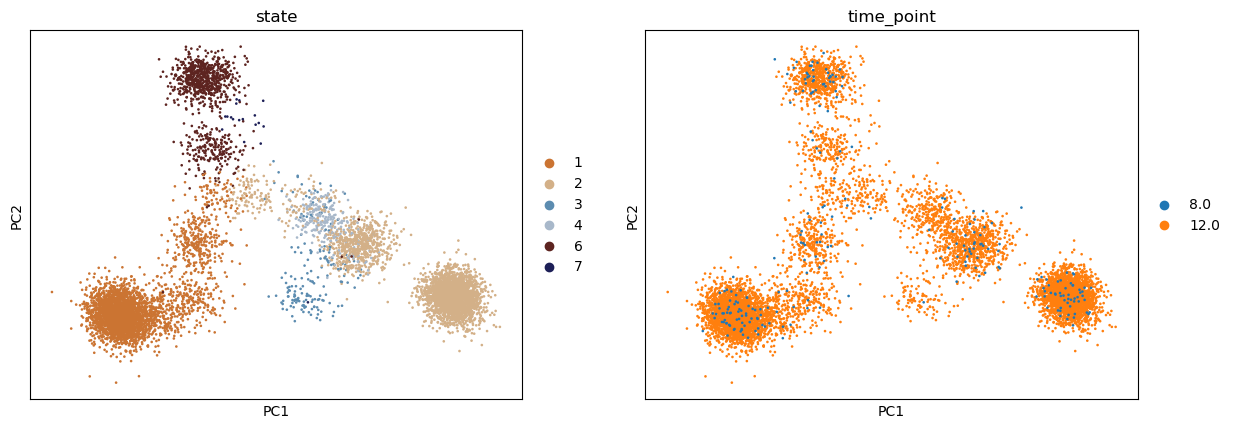

In [7]:
sc.pl.pca(adata, color=["state", "time_point"])

## Prepare the {class}`~moscot.problems.time.LineageProblem`

Apart from the `time_key` we need to set the `joint_attr` which defines the representation used to comptue distances. We will use the PCA space computed above. 


If we did not have precomputed cost matrices we could also set the `lineage_attr` to `{'attr': 'obsm', 'key': 'barcodes', 'cost': 'barcode_distance'}`, which computes the cost matrices based on barcodes.
Since the {class}`~anndata.AnnData` object already contains the precomputed cost matrices, we simply extract them, as shown below.

In [8]:
lp = LineageProblem(adata=adata)
lp = lp.prepare(
    time_key="time",
    joint_attr="X_pca",
    lineage_attr={"attr": "obsp", "key": "cost_matrices"},
)

## Solve the {class}`~moscot.problems.time.LineageProblem`

The `alpha` parameter determines the influence of the lineage term as opposed to the gene expression. It must be in  $(0, 1]$. We choose `epsilon` to be small to get a crisper transport map. Also, we allow a bit of unbalancedness to accomodate cellular growth and death by setting `tau_a < 1`. 

In [9]:
lp = lp.solve(alpha=0.99, epsilon=1e-3, tau_a=0.99)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(256, 8192)].                                   


## Analyzing cell type transitions

Now, we can compute the descendants of cells at time point `8`, aggregated by cell type. We order the annotations explicitly by providing a dictionary for `source_groups` and `target_groups`.

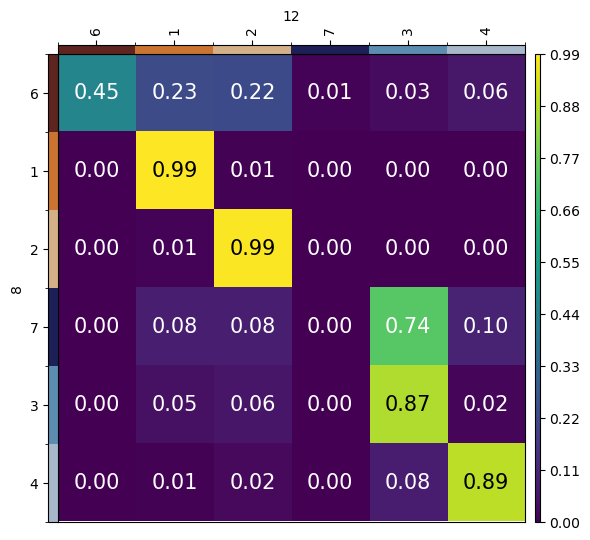

In [10]:
order = ["6", "1", "2", "7", "3", "4"]

cell_transition = lp.cell_transition(
    source=8,
    target=12,
    source_groups={"state": order},
    target_groups={"state": order},
    forward=True, 
    key_added="lp_transitions"
)

mpl.cell_transition(lp, fontsize=15, figsize=(5, 5), uns_key="lp_transitions")

Another way to visualize cell type transitions is using a Sankey diagram. 

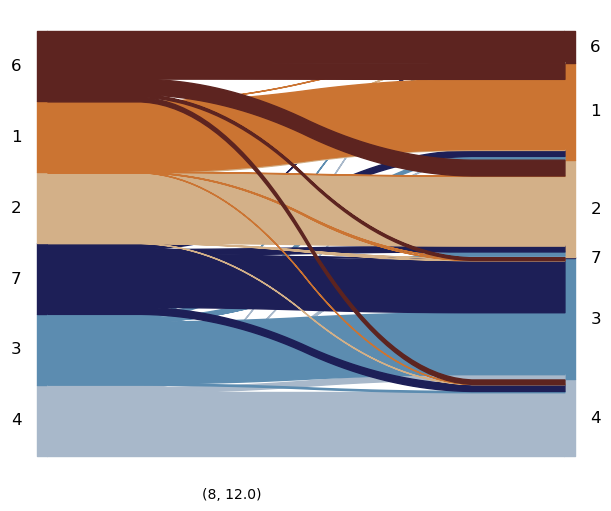

In [11]:
lp.sankey(
    source=8,
    target=12,
    source_groups={"state": order[::-1]},
    target_groups={"state": order[::-1]},
)
mpl.sankey(lp, figsize=(6, 5))

## Compare with ground truth and OT-baseline

Based on the lineage-tree that TedSim creates for the simluation, we can obtain a ground-truth coupling from early to late cells. Additionally, and as a baseline, we can just use simple OT to connect cells at the two time-point, ignoring the linege information. Let's see whether lineage information gets us closer to ground-truth. Start by extracting the ground-truth pre-computed coupling from the AnnData object. 

In [12]:
coupling_gt = adata.uns["couplings"]["true"].astype("float64")

For the OT-baseline, create a Temporal problem, prepare it using the same PCA representation as above, and solve it, using the same parameters as above. 

In [13]:
tp = TemporalProblem(adata)
tp = tp.prepare(time_key="time", joint_attr="X_pca")
tp = tp.solve(epsilon=1e-3, tau_a=0.99)

# compute the aggregated transition matrix
cell_transition = tp.cell_transition(
    source=8,
    target=12,
    source_groups={"state": order},
    target_groups={"state": order},
    forward=True,
    key_added="tp_transitions"
)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(256, 8192)].                                   


For the ground-truth solution, we instantiate a dummy temporal problem, which will make downstream plotting via moscot eatau_ar. 

In [14]:
# instantiate a dummy problem for this
gt = TemporalProblem(adata).prepare(time_key="time", joint_attr="X_pca")

# insert the ground-truth coupling 
out = MatrixSolverOutput(coupling_gt)
gt._problem_manager.get_solutions = lambda only_converged: {(8.0,12.0):out}

# set a few extra attributes
gt._stage = "solved"
gt.problems[8,12]._solution = out

# compute the aggregated transition matrix
cell_transition = gt.cell_transition(
    source=8,
    target=12,
    source_groups={"state": order},
    target_groups={"state": order},
    forward=True,
    key_added="gt_transitions"
)

Visualize the tree cases jointly

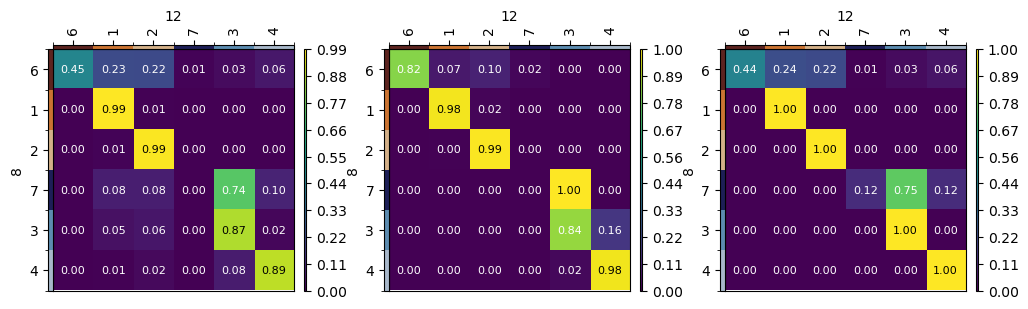

In [15]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

# moslin
axes[0] = mpl.cell_transition(lp, fontsize=8, figsize=(5, 5), return_fig=True, ax=axes[0], uns_key="lp_transitions")

# baseline OT
axes[1] = mpl.cell_transition(tp, fontsize=8, figsize=(5, 5), return_fig=True, ax=axes[1], uns_key="tp_transitions")

# ground-truth
axes[2] = mpl.cell_transition(gt, fontsize=8, figsize=(5, 5), return_fig=True, ax=axes[2], uns_key="gt_transitions")

fig.subplots_adjust(wspace=0.3)

plt.show()

Quantify this by computing the descendand error for both moslin and the OT baseline. Extract the coupling matrices. 

In [16]:
coupling_moslin = np.array(lp.solutions[8, 12].transport_matrix, dtype="float64")
coupling_ot = np.array(tp.solutions[8, 12].transport_matrix, dtype="float64")
coupling_outer = np.array(adata.uns["couplings"]["independent"], dtype="float64")

Use these to compute ancestor and descendant errors. 

In [17]:
# compute errors for moslin
anc_moslin, desc_moslin = compute_errors(adata, p_1=coupling_moslin, p_2=coupling_gt)

# compute errors for the OT approach
anc_ot, desc_ot = compute_errors(adata, p_1=coupling_ot, p_2=coupling_gt)

# compute errors for an uninformative coupling as baseline
anc_outer, desc_outer = compute_errors(adata, p_1=coupling_outer, p_2=coupling_gt)

100%|████████████████████████████████████████████████████████████████| 256/256 [01:11<00:00,  3.57it/s]


To obtain an interpretable number between 0 (ground-truth) and 1 (uninformative), we average over single-cells, normalize with the uninformative coupling, and take the mean over ancestor and descendant errors for both methods: 

In [19]:
mean_error_moslin = (np.mean(anc_moslin) / np.mean(anc_outer) + np.mean(desc_moslin) / np.mean(desc_outer)) / 2
mean_error_ot = (np.mean(anc_ot) / np.mean(anc_outer) + np.mean(desc_ot) / np.mean(desc_outer)) / 2

print(f"Mean error moslin = {mean_error_moslin:.2f}, mean error OT = {mean_error_ot:.2f}.")

Mean error moslin = 0.32, mean error OT = 0.60.


Moslin's performance on this dataset is much better, compared to the baseline OT approach. 

## Zoom into one population

We've seen above that moslin achieves a much better performance compared to a baseline OT approach for predicting ancestors and descendants across all cells. Let's zoom in to visualize what this means for a particular cell state. 

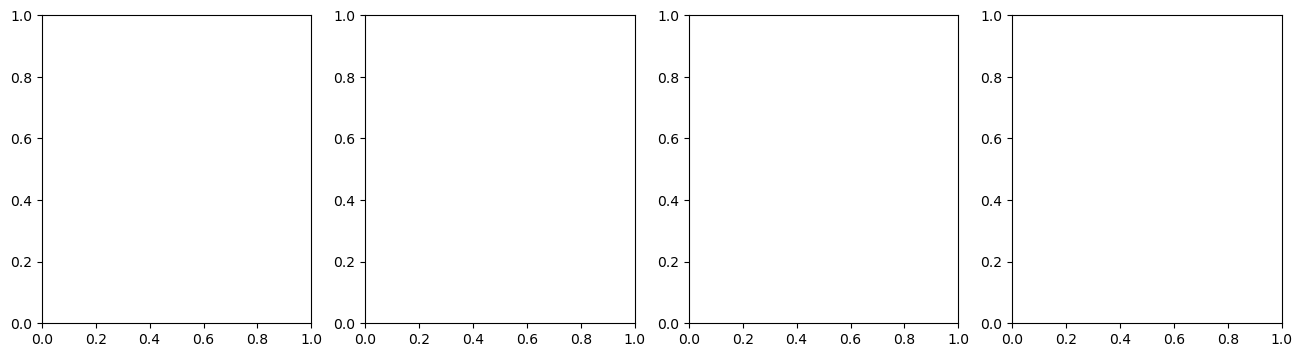

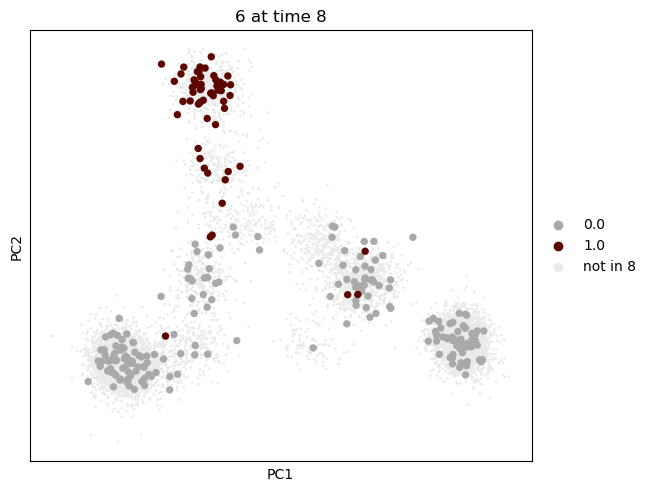

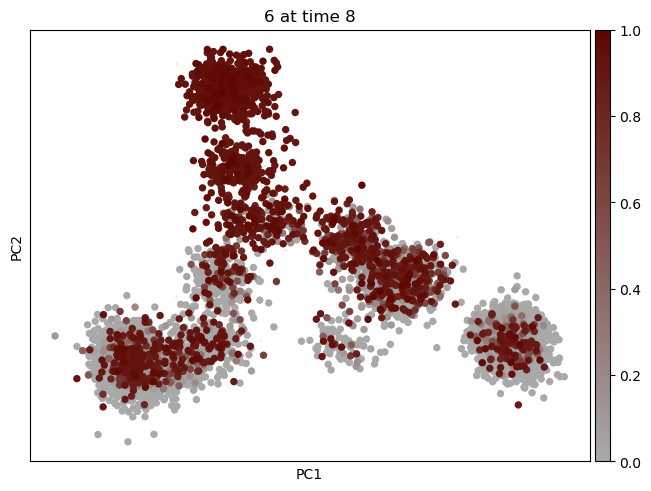

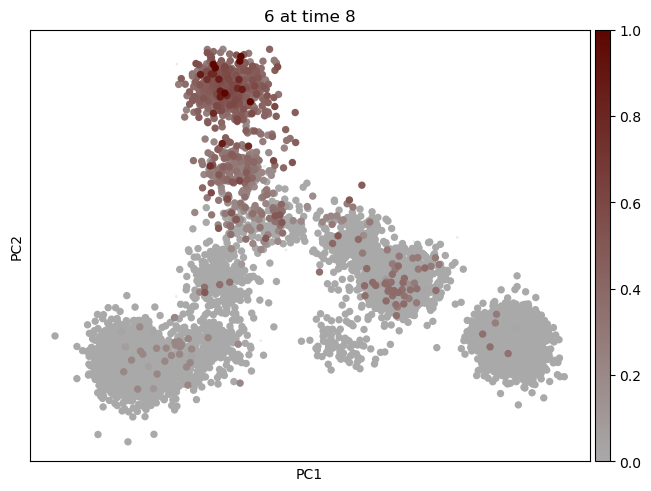

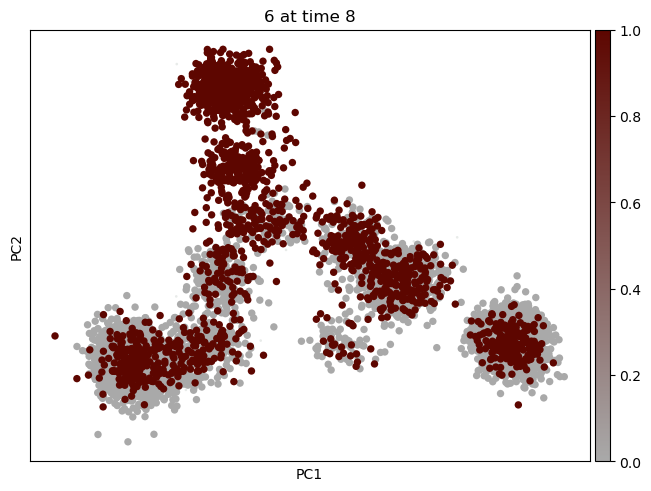

In [20]:
# compute the push-forward
common_kwargs = {"source": 8, "target": 12, "data": "state", "subset": "6"}
lp.push(key_added="lp_transitions", **common_kwargs)
tp.push(key_added="tp_transitions", **common_kwargs)
gt.push(key_added="gt_transitions", **common_kwargs)

fig, axes = plt.subplots(ncols=4, figsize=(16, 4))

# show the state at the early time point
pl_kwargs = { "basis": "pca", "dot_scale_factor": 8, "return_fig": True}
axes[0] = mpl.push(lp, time_points=[8], uns_key="lp_transitions", ax=axes[0], **pl_kwargs)

# visualize the various push distributions
axes[1] = mpl.push(lp, time_points=[12], uns_key="lp_transitions", ax=axes[1], **pl_kwargs)
axes[2] = mpl.push(tp, time_points=[12], uns_key="tp_transitions", ax=axes[2], **pl_kwargs)
axes[3] = mpl.push(gt, time_points=[12], uns_key="gt_transitions", ax=axes[3], **pl_kwargs)

plt.show()

moslin's predicted descendant distribution for this state is much closer to ground truth compared to what OT gives us. 